In [1]:
import polars as pl
import polars.selectors as cs

import altair as alt
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

import hvplot.polars

import datetime as dt

In [2]:
anime_path = r"F:\Datasets\CSV datasets\Anime Dataset\Anime.csv"

In [3]:
movie_rating_path = r"F:\Datasets\CSV datasets\Anime Dataset\Movie_Rating.csv"

In [4]:
anime_df = pl.read_csv(anime_path)

In [5]:
anime_df

anime_id,name,genre,type,episodes,rating,members
i64,str,str,str,str,f64,i64
32281,"""Kimi no Na wa.""","""Drama, Romance, School, Supern…","""Movie""","""1""",9.37,200630
5114,"""Fullmetal Alchemist: Brotherho…","""Action, Adventure, Drama, Fant…","""TV""","""64""",9.26,793665
28977,"""Gintama°""","""Action, Comedy, Historical, Pa…","""TV""","""51""",9.25,114262
9253,"""Steins;Gate""","""Sci-Fi, Thriller""","""TV""","""24""",9.17,673572
9969,"""Gintama&#039;""","""Action, Comedy, Historical, Pa…","""TV""","""51""",9.16,151266
…,…,…,…,…,…,…
9316,"""Toushindai My Lover: Minami ta…","""Hentai""","""OVA""","""1""",4.15,211
5543,"""Under World""","""Hentai""","""OVA""","""1""",4.28,183
5621,"""Violence Gekiga David no Hoshi""","""Hentai""","""OVA""","""4""",4.88,219


In [6]:
movie_rating_df = pl.read_csv(movie_rating_path)

In [7]:
movie_rating_df

user_id,anime_id,rating
i64,i64,i64
1,20,-1
1,24,-1
1,79,-1
1,226,-1
1,241,-1
…,…,…
73515,16512,7
73515,17187,9
73515,22145,10


In [8]:
combined_df = anime_df.join(movie_rating_df, on="anime_id", how="left")

In [9]:
combined_df

anime_id,name,genre,type,episodes,rating,members,user_id,rating_right
i64,str,str,str,str,f64,i64,i64,i64
32281,"""Kimi no Na wa.""","""Drama, Romance, School, Supern…","""Movie""","""1""",9.37,200630,99,5
32281,"""Kimi no Na wa.""","""Drama, Romance, School, Supern…","""Movie""","""1""",9.37,200630,152,10
32281,"""Kimi no Na wa.""","""Drama, Romance, School, Supern…","""Movie""","""1""",9.37,200630,244,10
32281,"""Kimi no Na wa.""","""Drama, Romance, School, Supern…","""Movie""","""1""",9.37,200630,271,10
32281,"""Kimi no Na wa.""","""Drama, Romance, School, Supern…","""Movie""","""1""",9.37,200630,278,-1
…,…,…,…,…,…,…,…,…
6133,"""Violence Gekiga Shin David no …","""Hentai""","""OVA""","""1""",4.98,175,39532,-1
6133,"""Violence Gekiga Shin David no …","""Hentai""","""OVA""","""1""",4.98,175,48766,-1
6133,"""Violence Gekiga Shin David no …","""Hentai""","""OVA""","""1""",4.98,175,60365,4


In [10]:
combined_df.collect_schema()

Schema([('anime_id', Int64),
        ('name', String),
        ('genre', String),
        ('type', String),
        ('episodes', String),
        ('rating', Float64),
        ('members', Int64),
        ('user_id', Int64),
        ('rating_right', Int64)])

In [11]:
combined_df = combined_df.with_columns(
    pl.col('anime_id').cast(pl.UInt16),
    pl.col('rating').cast(pl.Float32),
    pl.col('members').cast(pl.UInt32),
    pl.col('user_id').cast(pl.UInt32),
    pl.col('rating_right').cast(pl.Int8),
)

In [12]:
combined_df = combined_df.with_columns(
    pl.col('genre').str.split(',')
).explode('genre')

In [13]:
combined_df = combined_df.with_columns(
    pl.col('genre').str.strip_chars()
)

In [14]:
most_popular_genres = combined_df.select(
    pl.col('genre')
).group_by(
    pl.col('genre')
).len().sort(by='len', descending=True)

In [15]:
most_popular_genres

genre,len
str,u32
"""Comedy""",3909159
"""Action""",3263552
"""Romance""",2487946
"""Drama""",2101478
"""Fantasy""",2021538
…,…
"""Shounen Ai""",59724
"""Yaoi""",29170
"""Cars""",21340


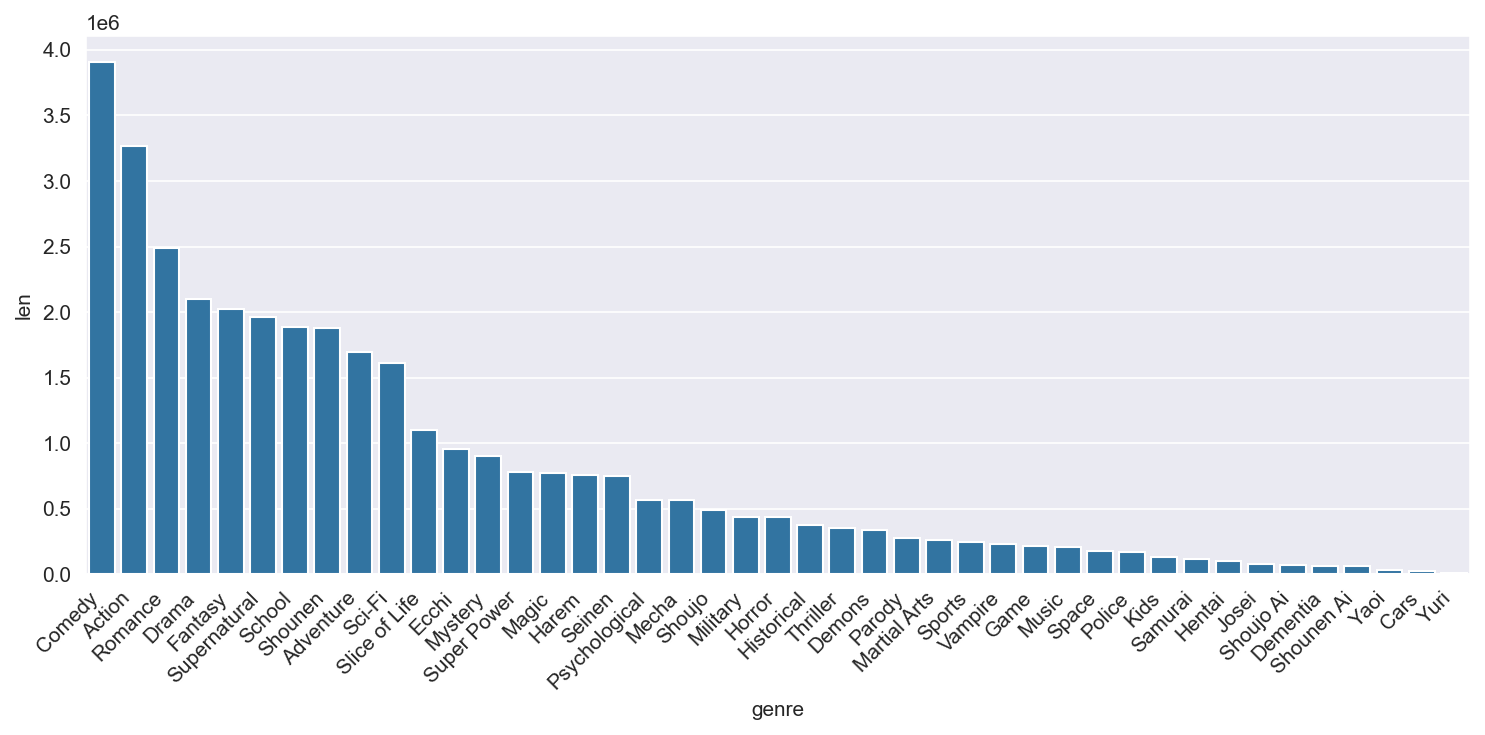

In [16]:
plt.figure(figsize=(10, 5), dpi=150)

most_popular_genres_pd = most_popular_genres.to_pandas()

sns.barplot(
    data=most_popular_genres_pd,
    x='genre',
    y='len'
)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [17]:
combined_df

anime_id,name,genre,type,episodes,rating,members,user_id,rating_right
u16,str,str,str,str,f32,u32,u32,i8
32281,"""Kimi no Na wa.""","""Drama""","""Movie""","""1""",9.37,200630,99,5
32281,"""Kimi no Na wa.""","""Romance""","""Movie""","""1""",9.37,200630,99,5
32281,"""Kimi no Na wa.""","""School""","""Movie""","""1""",9.37,200630,99,5
32281,"""Kimi no Na wa.""","""Supernatural""","""Movie""","""1""",9.37,200630,99,5
32281,"""Kimi no Na wa.""","""Drama""","""Movie""","""1""",9.37,200630,152,10
…,…,…,…,…,…,…,…,…
6133,"""Violence Gekiga Shin David no …","""Hentai""","""OVA""","""1""",4.98,175,39532,-1
6133,"""Violence Gekiga Shin David no …","""Hentai""","""OVA""","""1""",4.98,175,48766,-1
6133,"""Violence Gekiga Shin David no …","""Hentai""","""OVA""","""1""",4.98,175,60365,4


In [18]:
exact_duplicates = combined_df.group_by(
    ['user_id', 'anime_id', 'genre']
).len().filter(
    pl.col('len') > 1
)

In [19]:
exact_duplicates

user_id,anime_id,genre,len
u32,u16,str,u32
42653,22319,"""Psychological""",2
42653,16498,"""Fantasy""",2
42653,11757,"""Action""",2
45659,28367,"""Shounen""",2
42653,11757,"""Game""",2
…,…,…,…
42653,1575,"""Super Power""",2
42653,22319,"""Mystery""",2
42653,16498,"""Shounen""",2


In [20]:
user_anime_genre_counts = combined_df.group_by(
    ['user_id', 'anime_id']
).agg([
    pl.col('genre').n_unique().alias('unique_genres'),
    pl.col('genre').len().alias('total_genre_rows')
])

In [21]:
user_anime_genre_counts

user_id,anime_id,unique_genres,total_genre_rows
u32,u16,u32,u32
41750,2577,4,4
56535,7647,3,3
59588,995,4,4
45898,14227,5,5
22470,15751,5,5
…,…,…,…
18078,28025,3,3
61511,2994,5,5
3303,6347,4,4


In [22]:
combined_df.group_by(
    ['user_id', 'anime_id']
).agg([
    pl.col('rating_right').n_unique().alias('unique_ratings'),
    pl.col('rating_right').min().alias('min_rating'),
    pl.col('rating_right').max().alias('max_rating'),
    pl.col('genre').len().alias('genre_count'),
])

user_id,anime_id,unique_ratings,min_rating,max_rating,genre_count
u32,u16,u32,i8,i8,u32
6406,12355,1,10,10,2
9867,1562,1,8,8,2
55635,182,1,10,10,5
66179,2034,1,-1,-1,3
28175,9656,1,5,5,4
…,…,…,…,…,…
36801,4015,1,-1,-1,4
35784,10589,1,-1,-1,6
66505,23289,1,9,9,3


In [23]:
combined_df.select(
    (pl.col(col).is_null().sum() / pl.len() * 100).alias(f"{col}_null_percentage")
    for col in combined_df.columns
)

anime_id_null_percentage,name_null_percentage,genre_null_percentage,type_null_percentage,episodes_null_percentage,rating_null_percentage,members_null_percentage,user_id_null_percentage,rating_right_null_percentage
f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,0.0,0.000401,0.000206,0.0,0.002039,0.0,0.007401,0.007401


In [24]:
genre_analysis = combined_df.select(
    'genre'
).group_by(
    'genre'
).len().sort(
    by='len', descending=True
)

genre_analysis

genre,len
str,u32
"""Comedy""",3909159
"""Action""",3263552
"""Romance""",2487946
"""Drama""",2101478
"""Fantasy""",2021538
…,…
"""Shounen Ai""",59724
"""Yaoi""",29170
"""Cars""",21340


In [25]:
genre_variations = combined_df.select(
    'genre'
).unique().sort(
    'genre'
)

genre_variations.to_pandas()['genre'].tolist()

[None,
 'Action',
 'Adventure',
 'Cars',
 'Comedy',
 'Dementia',
 'Demons',
 'Drama',
 'Ecchi',
 'Fantasy',
 'Game',
 'Harem',
 'Hentai',
 'Historical',
 'Horror',
 'Josei',
 'Kids',
 'Magic',
 'Martial Arts',
 'Mecha',
 'Military',
 'Music',
 'Mystery',
 'Parody',
 'Police',
 'Psychological',
 'Romance',
 'Samurai',
 'School',
 'Sci-Fi',
 'Seinen',
 'Shoujo',
 'Shoujo Ai',
 'Shounen',
 'Shounen Ai',
 'Slice of Life',
 'Space',
 'Sports',
 'Super Power',
 'Supernatural',
 'Thriller',
 'Vampire',
 'Yaoi',
 'Yuri']

In [26]:
combined_df.select(
    pl.col('genre')
).unique().to_series().to_list()

['Adventure',
 'Shounen',
 'Drama',
 'Space',
 'Parody',
 'Seinen',
 'Music',
 'Sci-Fi',
 'Historical',
 'Military',
 'Shoujo',
 'Kids',
 'Slice of Life',
 'Hentai',
 'Police',
 'Game',
 'Magic',
 'Action',
 'Shounen Ai',
 'Horror',
 'Sports',
 None,
 'Yuri',
 'Comedy',
 'Romance',
 'Yaoi',
 'Shoujo Ai',
 'Super Power',
 'Supernatural',
 'Psychological',
 'Ecchi',
 'Dementia',
 'Mystery',
 'Martial Arts',
 'Demons',
 'Cars',
 'School',
 'Fantasy',
 'Harem',
 'Vampire',
 'Thriller',
 'Josei',
 'Mecha',
 'Samurai']

In [27]:
combined_df.select(
    'genre'
).to_dict(as_series=False)

{'genre': ['Drama',
  'Romance',
  'School',
  'Supernatural',
  'Drama',
  'Romance',
  'School',
  'Supernatural',
  'Drama',
  'Romance',
  'School',
  'Supernatural',
  'Drama',
  'Romance',
  'School',
  'Supernatural',
  'Drama',
  'Romance',
  'School',
  'Supernatural',
  'Drama',
  'Romance',
  'School',
  'Supernatural',
  'Drama',
  'Romance',
  'School',
  'Supernatural',
  'Drama',
  'Romance',
  'School',
  'Supernatural',
  'Drama',
  'Romance',
  'School',
  'Supernatural',
  'Drama',
  'Romance',
  'School',
  'Supernatural',
  'Drama',
  'Romance',
  'School',
  'Supernatural',
  'Drama',
  'Romance',
  'School',
  'Supernatural',
  'Drama',
  'Romance',
  'School',
  'Supernatural',
  'Drama',
  'Romance',
  'School',
  'Supernatural',
  'Drama',
  'Romance',
  'School',
  'Supernatural',
  'Drama',
  'Romance',
  'School',
  'Supernatural',
  'Drama',
  'Romance',
  'School',
  'Supernatural',
  'Drama',
  'Romance',
  'School',
  'Supernatural',
  'Drama',
  'Roman

In [28]:
import re

def normalize_genre_name(genre_name):
    if genre_name is None:
        return None

    normalized = genre_name.lower().strip()

    variations = {
        'sci-fi': 's'
    }


In [29]:
def create_genre_taxonomy():
    genre_taxonomy = {
        'Action': ['Action', 'Fighting', 'Martial Arts', 'Military', 'Police'],
        'Adventure': ['Adventure', 'Space'],
        'Comedy': ['Comedy', 'Parody', 'Gag Humor'],
        'Drama': ['Drama', 'Melodrama'],
        'Fantasy': ['Fantasy', 'Magic', 'Supernatural', 'Mythology'],
        'Romance': ['Romance', 'Romantic Comedy', 'Harem', 'Reverse Harem'],
        'Science Fiction': ['Science Fiction', 'Sci-Fi', 'Mecha', 'Cyberpunk'],
        'Horror': ['Horror', 'Thriller', 'Suspense'],
        'Mystery': ['Mystery', 'Detective', 'Psychological'],
        'Slice of Life': ['Slice of Life', 'Iyashikei', 'School', 'Workplace'],
        'Sports': ['Sports', 'Racing', 'Competition'],
        'Demographic': ['Shonen', 'Shojo', 'Seinen', 'Josei', 'Kids'],
        'Mature': ['Ecchi', 'Mature', 'Adult'],
        'Historical': ['Historical', 'Samurai', 'Period Drama'],
        'Music': ['Music', 'Idol', 'Band'],
        'Game': ['Game', 'Video Game', 'Card Game'],
        'Other': ['Experimental', 'Avant Garde', 'Art House']
    }

    return genre_taxonomy


In [30]:
combined_df.select([
    'anime_id', 'name', 'rating', 'type', 'episodes', 'genre'
]).describe()

statistic,anime_id,name,rating,type,episodes,genre
str,f64,str,f64,str,str,str
"""count""",3.48751e7,"""34875100""",3.4874389e7,"""34875028""","""34875100""","""34874960"""
"""null_count""",0.0,"""0""",711.0,"""72""","""0""","""140"""
"""mean""",8458.635314,null,7.692898,null,null,null
"""std""",8850.838417,null,0.640518,null,null,null
"""min""",1.0,"""&quot;0&quot;""",1.67,"""Movie""","""1""","""Action"""
"""25%""",916.0,null,7.3,null,null,null
"""50%""",5258.0,null,7.7,null,null,null
"""75%""",13357.0,null,8.15,null,null,null
"""max""",34527.0,"""◯""",10.0,"""TV""","""Unknown""","""Yuri"""


# User Behavior Analytics
## 4. User Engagement Segmentation:

In [31]:
combined_df.group_by(
    'user_id'
).agg(
    pl.col('anime_id').n_unique().alias('anime_count'),
    pl.col('rating_right').alias('total_rating'),
    pl.col('rating_right').mean().alias('avg_user_rating'),
    pl.col('rating_right').std().alias('rating_variance'),
    pl.col('rating_right').min().alias('min_rating'),
    pl.col('rating_right').max().alias('max_rating'),
    pl.col('genre').n_unique().alias('unique_genres'),
    pl.col('genre').len().alias('total_genre_interections'),
    pl.col('type').n_unique().alias('unique_types')
)

user_id,anime_count,total_rating,avg_user_rating,rating_variance,min_rating,max_rating,unique_genres,total_genre_interections,unique_types
u32,u32,list[i8],f64,f64,i8,i8,u32,u32,u32
72110,167,"[5, 5, … 5]",8.165919,2.149566,-1,10,30,669,5
32911,50,"[9, 9, … 8]",8.680672,1.094156,6,10,29,238,3
49691,123,"[10, 10, … -1]",6.512,3.305103,-1,10,38,500,4
7616,178,"[9, 9, … 4]",7.88366,1.094157,4,10,38,765,6
8536,18,"[10, 10, … 9]",8.552381,2.042721,-1,10,32,105,3
…,…,…,…,…,…,…,…,…,…
15988,246,"[10, 10, … 1]",6.468468,2.121735,-1,10,41,999,6
45085,49,"[10, 10, … 9]",9.134529,1.026593,6,10,29,223,4
17039,1,"[10, 10, … 10]",10.0,0.0,10,10,5,5,1


# Rating Bias Detection:

In [32]:
combined_df.select(
    pl.col('rating_right').mean().alias('global_avg_rating'),
)

global_avg_rating
f64
6.197278


In [33]:
combined_df.group_by(
    pl.col('anime_id')
).agg(
    pl.col('rating_right').mean().alias('anime_avg_rating'),
)

anime_id,anime_avg_rating
u16,f64
6032,5.404255
8533,3.4
33691,null
17959,3.666667
539,6.041106
…,…
2090,5.632653
31711,5.879713
28829,null


In [34]:
combined_df.group_by(
    'genre'
).agg(
    pl.col('rating_right').mean().alias('genre_avg_rating'),
)

genre,genre_avg_rating
str,f64
"""Hentai""",4.309465
"""Mystery""",6.495365
"""Mecha""",6.250968
"""Sci-Fi""",6.208801
null,3.372727
…,…
"""Space""",6.295652
"""Josei""",6.541593
"""Music""",6.144482


In [35]:
user_journey_df = combined_df.filter(
    pl.col('rating_right').is_not_null()
).group_by('user_id').agg(
    pl.col('rating_right').mean().alias('avg_user_rating'),
    pl.col('rating_right').std().alias('rating_std_dev'),
    pl.col('genre').n_unique().alias('unique_genres_count')
)

user_journey_df

user_id,avg_user_rating,rating_std_dev,unique_genres_count
u32,f64,f64,u32
46934,8.491228,2.597001,24
63982,7.162162,1.696306,23
37758,8.0,0.0,5
3022,-0.636792,1.970196,31
32777,3.074074,5.007117,13
…,…,…,…
4576,5.986111,4.588697,20
10480,8.396907,0.876989,31
52945,-1.0,0.0,36


In [36]:
genre_exploration_threshold = user_journey_df.select(
    pl.col('unique_genres_count').mean()
).item()

genre_exploration_threshold


27.877031898252056

In [37]:
user_journey_df = user_journey_df.with_columns(
    pl.when(pl.col('unique_genres_count') > genre_exploration_threshold)
    .then(pl.lit('Explorer'))
    .otherwise(pl.lit('Specialist'))
    .alias('user_type')
)

user_journey_df


user_id,avg_user_rating,rating_std_dev,unique_genres_count,user_type
u32,f64,f64,u32,str
46934,8.491228,2.597001,24,"""Specialist"""
63982,7.162162,1.696306,23,"""Specialist"""
37758,8.0,0.0,5,"""Specialist"""
3022,-0.636792,1.970196,31,"""Explorer"""
32777,3.074074,5.007117,13,"""Specialist"""
…,…,…,…,…
4576,5.986111,4.588697,20,"""Specialist"""
10480,8.396907,0.876989,31,"""Explorer"""
52945,-1.0,0.0,36,"""Explorer"""


In [38]:
user_segment_analysis = user_journey_df.group_by(
    'user_type'
).agg(
    pl.col('avg_user_rating').mean().alias('mean_of_average_ratings'),
    pl.col('rating_std_dev').mean().alias('mean_of_rating_std_dev'),
    pl.len().alias('user_count')
)

user_segment_analysis

user_type,mean_of_average_ratings,mean_of_rating_std_dev,user_count
str,f64,f64,u32
"""Explorer""",6.35648,1.968095,44955
"""Specialist""",7.171652,1.605419,28560


In [39]:
fig = px.bar(
    user_segment_analysis.to_pandas(),
    x='user_type',
    y=['mean_of_average_ratings', 'mean_of_rating_std_dev'],
    barmode='group',
    title='Rating Patterns: Genre Specialists vs. Explorers',
    labels={'user_type': 'User Type', 'value': 'Rating Metric', 'variable': 'Metric'}
)
fig.show()

# Content Intelligence

In [40]:
C = combined_df.select(
    pl.col('rating_right').mean()
).item()

print(f"Mean rating across all anime (C): {C:.2f}")

Mean rating across all anime (C): 6.20


In [41]:
anime_stats_df = combined_df.group_by(
    ['anime_id', 'name']
).agg(
    pl.col('rating_right').count().alias('v'),
    pl.col('rating_right').mean().alias('R'),
).drop_nulls()

anime_stats_df

anime_id,name,v,R
u16,str,u32,f64
1601,"""Red Garden""",1160,5.739655
32468,"""Nirvana""",30,5.233333
1986,"""Wakusei Robo Danguard Ace""",42,4.5
8442,"""Maze☆Bakunetsu Jikuu: Tenpen K…",15,4.0
24921,"""Aoki Hagane no Arpeggio: Ars N…",675,6.431111
…,…,…,…
9352,"""Tenshi no Habataki Jun""",4,2.75
10534,"""Doraemon Movie 31: Shin Nobita…",260,5.653846
8475,"""Asura""",1286,5.866252


In [42]:
m =  anime_stats_df.select(pl.col('v').quantile(0.9, "higher")).item()
print(f"Minimum ratings required (m): {m}")

Minimum ratings required (m): 7424.0


In [43]:
anime_popularity_df = anime_stats_df.with_columns(
    popularity_score = ((pl.col('v') / (pl.col('v') + m)) * pl.col('R') + (m / (pl.col('v') + m)) * C)
)

anime_popularity_df

anime_id,name,v,R,popularity_score
u16,str,u32,f64,f64
1601,"""Red Garden""",1160,5.739655,6.135437
32468,"""Nirvana""",30,5.233333,6.193399
1986,"""Wakusei Robo Danguard Ace""",42,4.5,6.18773
8442,"""Maze☆Bakunetsu Jikuu: Tenpen K…",15,4.0,6.192848
24921,"""Aoki Hagane no Arpeggio: Ars N…",675,6.431111,6.216767
…,…,…,…,…
9352,"""Tenshi no Habataki Jun""",4,2.75,6.195422
10534,"""Doraemon Movie 31: Shin Nobita…",260,5.653846,6.178891
8475,"""Asura""",1286,5.866252,6.148404


In [44]:
top_10_popular_anime = anime_popularity_df.sort('popularity_score', descending=True).head(10)

top_10_popular_anime

anime_id,name,v,R,popularity_score
u16,str,u32,f64,f64
5114,"""Fullmetal Alchemist: Brotherho…",172018,8.028933,7.953153
9253,"""Steins;Gate""",38566,8.126796,7.815321
4181,"""Clannad: After Story""",89270,7.835275,7.709512
2904,"""Code Geass: Hangyaku no Lelouc…",145452,7.765943,7.689766
11061,"""Hunter x Hunter (2011)""",34300,7.924082,7.61683
2001,"""Tengen Toppa Gurren Lagann""",96685,7.709572,7.601731
1575,"""Code Geass: Hangyaku no Lelouc…",166308,7.641244,7.57954
23273,"""Shigatsu wa Kimi no Uso""",47240,7.740262,7.530708
19,"""Monster""",32158,7.809099,7.506786


In [45]:
fig = px.bar(
    top_10_popular_anime.to_pandas(),
    x='name',
    y='popularity_score',
    title='Top 10 Most Popular Anime by Composite Score',
    labels={'name': 'Anime', 'popularity_score': 'Popularity Score'},
    color='popularity_score',
    color_continuous_scale=px.colors.sequential.Viridis
)
fig.update_layout(xaxis_tickangle=-45)
fig.show()

In [46]:
anime_agg_df = combined_df.group_by(
    ['anime_id', 'name', 'type', 'episodes']
).agg(
    pl.col('rating_right').mean().alias('avg_rating'),
).drop_nulls()

anime_agg_df

anime_id,name,type,episodes,avg_rating
u16,str,str,str,f64
8074,"""Highschool of the Dead""","""TV""","""12""",6.324127
382,"""Futari Ecchi""","""OVA""","""4""",5.098842
22169,"""Fetish Doll""","""Movie""","""1""",1.0
6097,"""Heisei Harenchi Gakuen""","""OVA""","""1""",4.055556
7113,"""30th Gundam Perfect Mission""","""OVA""","""1""",5.461111
…,…,…,…,…
6945,"""Gintama: Shiroyasha Koutan""","""Special""","""1""",6.363982
8079,"""Tamala 2010: A Punk Cat in Spa…","""OVA""","""2""",5.285714
10278,"""The iDOLM@STER""","""TV""","""25""",6.249876


In [47]:
fig = px.scatter(
    anime_agg_df.to_pandas(),
    x='episodes',
    y='avg_rating',
    color='type',
    log_x=True,
    title='Episode Count vs. Average Rating by Type (Log Scale)',
    labels={'episodes': 'Episodes (log scale)', 'avg_rating': 'Average Rating'},
    hover_data=['name']
)
fig.show()

In [48]:
genre_df = combined_df.select(
    pl.col(['anime_id', 'genre'])
).unique()

genre_df

anime_id,genre
u16,str
27569,"""Comedy"""
34430,"""Action"""
20093,"""Comedy"""
1941,"""Space"""
4786,"""School"""
…,…
2905,"""School"""
4188,"""Shounen"""
2661,"""Comedy"""


In [49]:
episode_genre_df = anime_agg_df.join(genre_df, on='anime_id')
episode_genre_df


anime_id,name,type,episodes,avg_rating,genre
u16,str,str,str,f64,str
27569,"""Sore Ike! Anpanman: Hashire! W…","""Movie""","""1""",-1.0,"""Comedy"""
20093,"""Furiten-kun""","""Movie""","""1""",2.5,"""Comedy"""
1941,"""Moonlight Mile 1st Season: Lif…","""TV""","""12""",6.240437,"""Space"""
4786,"""Kodomo no Jikan Recap""","""OVA""","""1""",5.046512,"""School"""
9330,"""Dragon Crisis!""","""TV""","""12""",5.475699,"""Seinen"""
…,…,…,…,…,…
2905,"""Ikkitousen: Dragon Destiny Spe…","""Special""","""6""",5.023256,"""School"""
4188,"""Mahou Sensei Negima! Shiroki T…","""OVA""","""3""",5.40413,"""Shounen"""
2661,"""Doraemon Movie 13: Nobita to K…","""Movie""","""1""",5.126437,"""Comedy"""


In [50]:
episode_genre_df.group_by(
    'genre'
).agg(
    pl.col('avg_rating').mean().alias('avg_rating_per_genre'),
    pl.len().alias('anime_count'),
).sort('anime_count', descending=True)

genre,avg_rating_per_genre,anime_count
str,f64,u32
"""Comedy""",4.167371,4272
"""Action""",4.631743,2687
"""Adventure""",4.200292,2198
"""Fantasy""",4.081399,2108
"""Sci-Fi""",4.592254,1982
…,…,…
"""Shoujo Ai""",5.423386,54
"""Josei""",5.577465,52
"""Yuri""",3.981187,41


# Data Quality & Validation

In [51]:
combined_df.select(
    pl.col(['anime_id', 'user_id'])
).group_by(
    pl.col(['anime_id', 'user_id'])
).len().sort(
    'len', descending=True
)

anime_id,user_id,len
u16,u32,u32
22319,42653,14
2832,26535,13
2832,53528,13
2832,66858,13
2832,12339,13
…,…,…
5365,31340,1
3560,60365,1
5464,4749,1


In [52]:
combined_df.select(
    pl.col(['anime_id', 'user_id', 'rating_right'])
).filter(
    pl.col('rating_right').is_not_null()
).group_by(
    pl.col(['anime_id', 'user_id'])
).agg(
    pl.n_unique('rating_right').alias('unique_ratings')
).filter(
    pl.col('unique_ratings') > 1
)

anime_id,user_id,unique_ratings
u16,u32,u32
23283,42653,2
20507,42653,2
11757,42653,2
1575,42653,2
22319,42653,2
2001,42653,2


# 3. Analyze Member Count Consistency

In [57]:
combined_df_lazy = combined_df.lazy()

In [60]:
!nvidia-smi

Sun Jun 29 17:39:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.28                 Driver Version: 576.28         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  |   00000000:2B:00.0  On |                  N/A |
| 32%   41C    P3             27W /  170W |    4233MiB /  12288MiB |     10%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----